**Task 3:** Image captioning using a CNN with NetVLAD as encoder and a single hidden 
layer RNN based decoder.


In [1]:
# **Task 3:** Image captioning using a CNN with NetVLAD as encoder and a single hidden 
# layer RNN based decoder.


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
from collections import Counter
from itertools import chain


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# dataset structure:
# ./dataset/captioning/Images/ - contains all images
# ./dataset/captioning/image_names.txt - contains all image names that will be used for training. Rest of the images will be used for testing.
# note that the order of image names in image_names.txt is random.
# ./dataset/captioning/captions.txt - contains image names and 5 captions for each image.
# example from captions.txt:
# 1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
# 1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
# 1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
# 1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
# 1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
# 1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
# 1001773457_577c3a7d70.jpg#1	A black dog and a tri-colored dog playing with each other on the road .
# 1001773457_577c3a7d70.jpg#2	A black dog and a white dog with brown spots are staring at each other in the street .
# 1001773457_577c3a7d70.jpg#3	Two dogs of different breeds looking at each other on the road .
# 1001773457_577c3a7d70.jpg#4	Two dogs on pavement moving toward each other .

# again note that the order of image names in image_names.txt is random and not in the same order as in captions.txt.


In [5]:

class ImageCaptioningDataset(Dataset):
    def __init__(self, root_dir, captions_file, image_names_file, transform=None, split='train'):
        """
        Args:
            root_dir (string): Directory with all the images.
            captions_file (string): Path to the captions file.
            image_names_file (string): Path to the file with image names for training.
            transform (callable, optional): Optional transform to be applied on an image.
            split (string, optional): The dataset split, either 'train' or 'test'.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.split = split
        self.images = []
        self.captions = []
        self.image_names = set()

        # Load image names for training or testing
        with open(image_names_file, 'r') as f:
            for line in f:
                self.image_names.add(line.strip())

        # Load captions and associate them with images
        with open(captions_file, 'r') as f:
            for line in f:
                image_name, caption = line.strip().split('\t')
                image_name = image_name.split('#')[0]
                if (split == 'train' and image_name in self.image_names) or \
                   (split == 'test' and image_name not in self.image_names):
                    self.images.append(image_name)
                    self.captions.append(caption)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_name = self.images[idx]
        image_path = os.path.join(self.root_dir, 'Images', image_name)
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        caption = self.captions[idx]
        return image, caption

In [6]:
nltk.download('punkt')

class Vocabulary:
    def __init__(self, freq_threshold):
        # A counter to hold the frequency of each word
        self.freq_threshold = freq_threshold
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}

    def build_vocabulary(self, sentence_list):
        frequencies = Counter(chain(*sentence_list))
        # Only include words that appear at least freq_threshold times
        self.itos.update({idx + 4: token for idx, (token, count) in enumerate(frequencies.items()) if count >= self.freq_threshold})
        # Reverse the dictionary
        self.stoi = {token: idx for idx, token in self.itos.items()}

    def numericalize(self, text):
        # Convert each token to its index; if it's not in the vocabulary, replace it with <UNK>
        return [self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in text]

    def tokenize(self, text):
        return nltk.tokenize.word_tokenize(text.lower())

    def pad(self, numericalized_caption, max_length):
        # Pad the numericalized caption to the max_length with the <PAD> token index
        return numericalized_caption + ([self.stoi["<PAD>"]] * (max_length - len(numericalized_caption)))


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
# Define the NetVLAD layer
class NetVLAD(nn.Module):
    def __init__(self, num_clusters=2, dim=512, alpha=100.0, normalize_input=True):
        """
        Initialize the NetVLAD layer.
        
        Parameters:
        - num_clusters (int): The number of clusters to use.
        - dim (int): The dimension of the descriptors.
        - alpha (float): The parameter for controlling the soft assignment.
        - normalize_input (bool): Whether to normalize the input features.
        """
        super(NetVLAD, self).__init__()
        self.num_clusters = num_clusters
        self.dim = dim
        self.alpha = alpha
        self.normalize_input = normalize_input
        
        # Convolutional layer to compute soft assignment to clusters
        self.conv = nn.Conv2d(dim, num_clusters, kernel_size=(1, 1), bias=True)
        
        # The centroids for each cluster
        self.centroids = nn.Parameter(torch.rand(num_clusters, dim))
        
        # Initialize parameters
        self._init_params()

    def _init_params(self):
        """
        Initialize the parameters of the convolutional layer and centroids.
        """
        # Initialize the weights of the convolutional layer
        self.conv.weight = nn.Parameter(
            (2.0 * self.alpha * self.centroids).unsqueeze(-1).unsqueeze(-1)
        )
        # Initialize the biases of the convolutional layer
        self.conv.bias = nn.Parameter(
            - self.alpha * self.centroids.norm(dim=1)
        )

    def forward(self, x):
        """
        Forward pass of the NetVLAD layer.
        
        Parameters:
        - x (torch.Tensor): The input tensor with shape (N, C, H, W).
        
        Returns:
        - vlad (torch.Tensor): The NetVLAD descriptor for the input.
        """
        N, C = x.shape[:2]

        # Normalize the input if required
        if self.normalize_input:
            x = F.normalize(x, p=2, dim=1)

        # Compute soft assignment to clusters
        soft_assign = self.conv(x).view(N, self.num_clusters, -1)
        soft_assign = F.softmax(soft_assign, dim=1)

        # Flatten the input tensor
        x_flatten = x.view(N, C, -1)
        
        # Compute the residuals to each cluster centroid
        residual = x_flatten.expand(self.num_clusters, -1, -1, -1).permute(1, 0, 2, 3) - \
            self.centroids.expand(x_flatten.size(-1), -1, -1).permute(1, 2, 0).unsqueeze(0)
        residual *= soft_assign.unsqueeze(2)
        
        # Aggregate the residuals across all locations
        vlad = residual.sum(dim=-1)

        # Normalize the aggregated residuals
        vlad = F.normalize(vlad, p=2, dim=2)
        vlad = vlad.view(x.size(0), -1)
        vlad = F.normalize(vlad, p=2, dim=1)

        return vlad


In [8]:
base_model = models.resnet18(pretrained=True)
base_model = nn.Sequential(*list(base_model.children())[:-2])
print(base_model(torch.randn(1, 3, 224, 224)).shape) # torch.Size([1, 512, 7, 7])

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 512, 7, 7])


In [9]:
# Define the Encoder
class Encoder(nn.Module):
    def __init__(self, num_clusters=2, dim=512):  # k = 2
        super(Encoder, self).__init__()
        self.base_model = models.resnet18(pretrained=True)
        # Remove the last two layers (pooling and linear) from ResNet-18
        self.base_model = nn.Sequential(*list(self.base_model.children())[:-2])
        # Add NetVLAD layer
        self.net_vlad = NetVLAD(num_clusters=num_clusters, dim=dim)

    def forward(self, x):
        # Pass the input through the base CNN model
        x = self.base_model(x)
        # Pass the CNN features through the NetVLAD layer
        x = self.net_vlad(x)
        return x


In [10]:
class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, vocab_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, input_size)
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions, lengths):
        # Embed the input word indices
        embeddings = self.embedding(captions)
        # Concatenate the features from the encoder with the embeddings
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        # Pack the padded sequence so that the RNN ignores the <PAD> tokens
        packed = nn.utils.rnn.pack_padded_sequence(embeddings, lengths, batch_first=True)
        # Pass the embeddings through the RNN 
        rnn_out, hidden = self.rnn(packed)
        # Unpack the output 
        outputs, _ = nn.utils.rnn.pad_packed_sequence(rnn_out, batch_first=True)
        # Predict the next word
        outputs = self.out(outputs)
        return outputs, hidden
        # # Embed the input word indices
        # embeddings = self.embedding(captions)
        # # Concatenate the features from the encoder with the embeddings
        # embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        # # Pass the embeddings through the RNN
        # rnn_out, hidden = self.rnn(embeddings)
        # # Predict the next word
        # outputs = self.out(rnn_out)
        # return outputs, hidden

    def initHidden(self, batch_size, device):
        return torch.zeros(1, batch_size, self.hidden_size).to(device)


In [11]:
# Define the Image Captioning Model
class ImageCaptioningModel(nn.Module):
    def __init__(self, encoder, decoder):
        """
        Initialize the Image Captioning Model with an encoder and a decoder.
        
        Parameters:
        - encoder (nn.Module): The encoder model that extracts features from images.
        - decoder (nn.Module): The decoder model that generates captions from image features.
        """
        super(ImageCaptioningModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, images, captions, lengths):
        """
        Forward pass of the Image Captioning Model.
        
        Parameters:
        - images (torch.Tensor): Batch of input images.
        - captions (torch.Tensor): Batch of captions corresponding to the images.
        - lengths (list): Lengths of the captions in the batch.
        
        Returns:
        - outputs (torch.Tensor): The predicted captions for the images.
        """
        # Encode the images to get the features
        features = self.encoder(images)
        
        # Decode the features to get the captions
        outputs = self.decoder(features, captions, lengths)
        return outputs

    def sample(self, images, states=None, max_seq_length=20):
        """
        Generate captions for the given images using greedy search.
        
        Parameters:
        - images (torch.Tensor): Batch of input images.
        - states (tuple): Initial states for the decoder RNN.
        - max_seq_length (int): Maximum sequence length of the captions.
        
        Returns:
        - sampled_ids (list): The generated word indices for the captions.
        """
        # Encode the images to get the features
        features = self.encoder(images)
        sampled_ids = []
        inputs = features.unsqueeze(1)
        
        for i in range(max_seq_length):
            # Generate the next word
            hiddens, states = self.decoder.rnn(inputs, states)
            outputs = self.decoder.out(hiddens.squeeze(1))
            # Greedy search: select the word with highest probability
            _, predicted = outputs.max(1)
            sampled_ids.append(predicted)
            # Prepare the next input
            inputs = self.decoder.embedding(predicted)
            inputs = inputs.unsqueeze(1)
        
        # Stack the predicted indices
        sampled_ids = torch.stack(sampled_ids, 1)
        return sampled_ids


In [12]:
class Trainer:
    def __init__(self, model, optimizer, criterion, device, vocab):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.vocab = vocab  # Include the vocabulary in the trainer

    def train(self, data_loader, epochs):
        self.model.train()
        for epoch in range(epochs):
            total_loss = 0
            with tqdm(data_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as t_batch:
                for images, captions in t_batch:
                    # Tokenize and numericalize captions
                    captions = [self.vocab.tokenize(cap) for cap in captions]
                    captions = [self.vocab.numericalize(cap) for cap in captions]
                    # Calculate lengths and pad captions
                    lengths = [len(cap) for cap in captions]
                    # Sort captions and lengths in descending order of lengths
                    lengths, sort_idx = torch.tensor(lengths).sort(0, descending=True)
                    captions = [captions[i] for i in sort_idx]
                    images = images[sort_idx]
                    # Pad captions after sorting
                    captions = pad_sequence([torch.tensor(cap) for cap in captions],
                                            batch_first=True, padding_value=self.vocab.stoi["<PAD>"])
                    images, captions = images.to(self.device), captions.to(self.device)
                    lengths = lengths.to(self.device)
                    self.optimizer.zero_grad()
                    # Unpack the tuple returned by the model if it returns more than one output
                    outputs = self.model(images, captions[:, :-1], lengths)[0]
                    # Calculate loss
                    targets = pack_padded_sequence(captions[:, 1:], lengths, batch_first=True).data



                    # Ensure the outputs tensor is the correct shape for calculating loss
                    outputs = outputs.reshape(-1, outputs.shape[2])
                    # print outputs.shape, targets.shape
                    if outputs.shape[0] < targets.shape[0]:
                        targets = targets[:outputs.shape[0]]
                    else:
                        outputs = outputs[:targets.shape[0]]

                    print(outputs.shape, targets.shape)

                    loss = self.criterion(outputs, targets)
                    loss.backward()
                    self.optimizer.step()
                    # Update total loss
                    total_loss += loss.item()
                    t_batch.set_postfix(loss=total_loss / (t_batch.n + 1))
            # Print average loss for the epoch
            avg_loss = total_loss / len(data_loader)
            print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')


In [13]:
class Evaluator:
    def __init__(self, model, device, vocab):
        self.model = model.to(device)
        self.device = device
        self.vocab = vocab

    def evaluate(self, data_loader):
        self.model.eval()
        references = []
        hypotheses = []
        with torch.no_grad():
            for images, captions, lengths in data_loader:
                images = images.to(self.device)
                # Generate captions using the model
                outputs = self.model.sample(images)
                # Convert word indices to words
                for i in range(images.size(0)):
                    # References
                    img_captions = [captions[j][i].tolist() for j in range(len(captions))]
                    img_captions = list(map(lambda c: [w for w in c if w not in {self.vocab.stoi['<SOS>'], self.vocab.stoi['<EOS>'], self.vocab.stoi['<PAD>']}], img_captions))
                    references.append(img_captions)
                    # Hypotheses
                    hypothesis = outputs[i].tolist()
                    hypothesis = [w for w in hypothesis if w not in {self.vocab.stoi['<SOS>'], self.vocab.stoi['<EOS>'], self.vocab.stoi['<PAD>']}]
                    hypotheses.append(hypothesis)

        # Calculate BLEU scores
        bleu1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0), smoothing_function=SmoothingFunction().method1)
        bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0), smoothing_function=SmoothingFunction().method1)
        bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0), smoothing_function=SmoothingFunction().method1)
        bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=SmoothingFunction().method1)

        return {'BLEU-1': bleu1, 'BLEU-2': bleu2, 'BLEU-3': bleu3, 'BLEU-4': bleu4}


In [14]:
# Define the hyperparameters
num_clusters = 2
dim = 512
input_size = num_clusters * dim
hidden_size = 512
# vocab_size = 10000
freq_threshold = 1
num_epochs = 10
batch_size = 32
learning_rate = 0.001


In [15]:
# Load the dataset and create data loaders
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = ImageCaptioningDataset(
    'dataset/captioning', 'dataset/captioning/captions.txt', 'dataset/captioning/image_names.txt',
    transform=transform, split='train')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = ImageCaptioningDataset(
    'dataset/captioning', 'dataset/captioning/captions.txt', 'dataset/captioning/image_names.txt',
    transform=transform, split='test')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


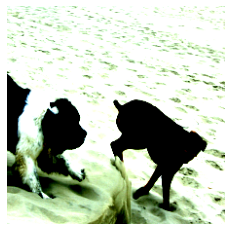

One dog is chasing another one on the beach .


In [16]:
# show an example image and caption
image, caption = train_dataset[122]
plt.imshow(image.permute(1, 2, 0))
plt.axis('off')
plt.show()
print(caption)


In [17]:
# Build the vocabulary
vocab = Vocabulary(freq_threshold=1)
# captions = []
# for _, caption in tqdm(train_dataset):
#     captions.append(vocab.tokenize(caption))

# vocab.build_vocabulary(captions)

# # save the vocabulary
# torch.save(vocab, 'models/Q3/vocab_1.pth')

# Load the vocabulary
vocab = torch.load('models/Q3/vocab_1.pth')
vocab_size = len(vocab.stoi)
print(f'Vocabulary size: {vocab_size}')


Vocabulary size: 6459


In [18]:
# Initialize the encoder and decoder
encoder = Encoder(num_clusters=num_clusters, dim=dim)
decoder = Decoder(input_size, hidden_size, vocab_size)
model = ImageCaptioningModel(encoder, decoder)

# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Train the model
trainer = Trainer(model, optimizer, criterion, device, vocab)
trainer.train(train_loader, num_epochs)

# Evaluate the model
evaluator = Evaluator(model, device, vocab)
scores = evaluator.evaluate(test_loader)
print(scores)



Epoch 1/10:   0%|          | 0/625 [00:00<?, ?batch/s]

torch.Size([420, 6459]) torch.Size([420])


Epoch 1/10:   0%|          | 1/625 [00:08<1:30:51,  8.74s/batch, loss=8.81]

torch.Size([352, 6459]) torch.Size([352])


Epoch 1/10:   0%|          | 2/625 [00:16<1:25:10,  8.20s/batch, loss=8.77]

torch.Size([400, 6459]) torch.Size([400])


Epoch 1/10:   0%|          | 3/625 [00:25<1:29:22,  8.62s/batch, loss=8.74]

torch.Size([390, 6459]) torch.Size([390])


Epoch 1/10:   1%|          | 4/625 [00:37<1:43:10,  9.97s/batch, loss=8.68]

torch.Size([371, 6459]) torch.Size([371])


Epoch 1/10:   1%|          | 5/625 [00:46<1:40:19,  9.71s/batch, loss=8.63]

torch.Size([395, 6459]) torch.Size([395])


Epoch 1/10:   1%|          | 6/625 [00:55<1:34:31,  9.16s/batch, loss=8.56]

torch.Size([357, 6459]) torch.Size([357])


Epoch 1/10:   1%|          | 7/625 [01:03<1:32:19,  8.96s/batch, loss=8.5] 

In [ ]:

# Save the model
torch.save(model, 'models/Q3/model.pth')

# Load the model
model = torch.load('models/Q3/model.pth')
model.eval()

# Generate captions for a sample image
image, caption = test_dataset[0]
image = image.unsqueeze(0).to(device)
sampled_ids = model.sample(image)
sampled_caption = []
for word_id in sampled_ids[0]:
    word = vocab.itos[word_id]
    sampled_caption.append(word)
    if word == '<EOS>':
        break
sampled_caption = ' '.join(sampled_caption)
print(sampled_caption)

# Display the sample image
plt.imshow(image.squeeze(0).permute(1, 2, 0).cpu())
plt.axis('off')
plt.show()
print(caption)
